# 資料預處理

## 二值化

將原圖轉為黑白
DEMO:

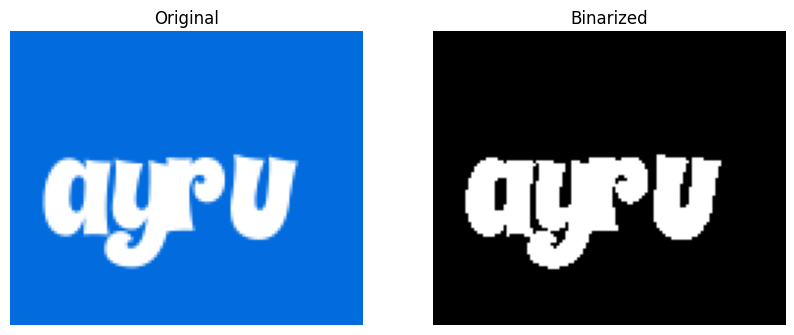

In [14]:
import cv2
import matplotlib.pyplot as plt

# 讀取圖片 (BGR)
img = cv2.imread("test.png")

# 將 BGR 轉為 RGB，方便 matplotlib 正確顯示
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 轉灰階
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 二值化
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 顯示原圖與二值化結果
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Binarized")
plt.imshow(binary, cmap="gray")
plt.axis("off")

plt.show()


## bounding box cropping
切割 DEMO

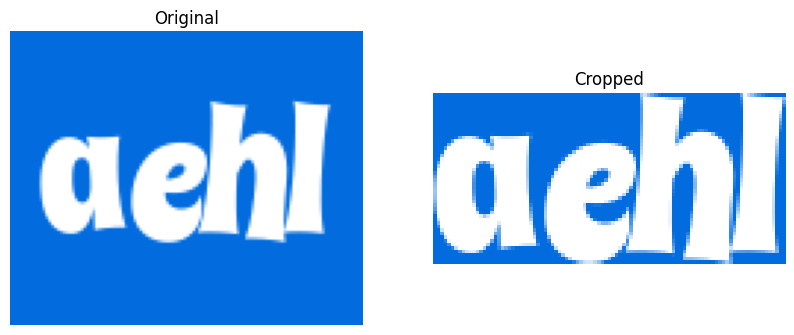

xmin=10, xmax=108, ymin=24, ymax=71


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取圖片
img = cv2.imread("test.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉成 RGB 方便 matplotlib 顯示

# 轉灰階
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 二值化（Otsu）
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 找出白色區域
ys, xs = np.where(binary == 255)

if len(xs) > 0 and len(ys) > 0:
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()

    # 切割白色區域
    cropped = img_rgb[ymin:ymax+1, xmin:xmax+1]

    # 顯示原圖與切割結果
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Cropped")
    plt.imshow(cropped)
    plt.axis("off")

    plt.show()

    print(f"xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}")
else:
    print("沒有偵測到白色區域")


批次處理

In [8]:
import cv2
import numpy as np
import os
from tqdm import tqdm  # 顯示進度條

# 資料夾設定
input_dir = "captcha_raw"
output_dir = "captcha_cooked"

# 建立輸出資料夾（若不存在）
os.makedirs(output_dir, exist_ok=True)

# 取得所有 PNG 檔案
files = [f for f in os.listdir(input_dir) if f.lower().endswith('.png')]

# 批次處理
for f in tqdm(files, desc="Processing", unit="img"):
    input_path = os.path.join(input_dir, f)
    output_path = os.path.join(output_dir, f)

    # 讀取圖片
    img = cv2.imread(input_path)
    if img is None:
        continue  # 若讀取失敗則跳過

    # 轉灰階
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Otsu 二值化
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 找白色像素的位置
    ys, xs = np.where(binary == 255)

    if len(xs) > 0 and len(ys) > 0:
        xmin, xmax = xs.min(), xs.max()
        ymin, ymax = ys.min(), ys.max()

        # 切割原圖（保留原始 RGB）
        cropped = img[ymin:ymax+1, xmin:xmax+1]

        # 轉成灰階後再二值化，確保輸出是黑白
        gray_cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        _, binary_cropped = cv2.threshold(gray_cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # 儲存結果
        cv2.imwrite(output_path, binary_cropped)
    else:
        print(f"⚠️ No white region detected in {f}")


Processing: 100%|██████████| 467/467 [00:00<00:00, 1322.22img/s]


## 投影 + 形態學處理
DEMO

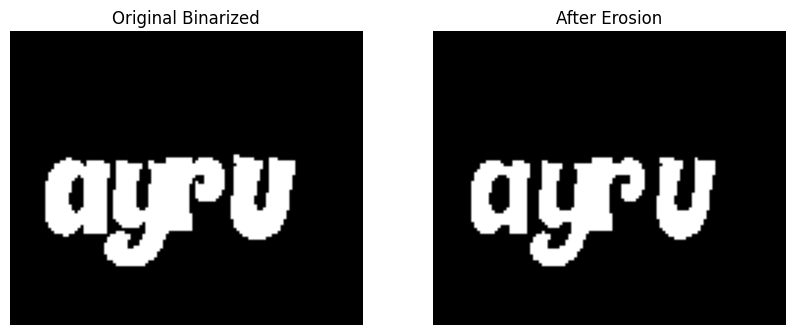

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取圖片
img = cv2.imread("test.png", cv2.IMREAD_GRAYSCALE)

# 二值化 (Otsu)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 建立結構元素 (kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))  # 可調整大小 (2,2) / (3,3)

# 進行腐蝕 (讓筆劃變細，嘗試分開黏在一起的字母)
eroded = cv2.erode(binary, kernel, iterations=1)

# 顯示原始與處理後差別
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Original Binarized")
plt.imshow(binary, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("After Erosion")
plt.imshow(eroded, cmap="gray")
plt.axis("off")

plt.show()


垂直投影法

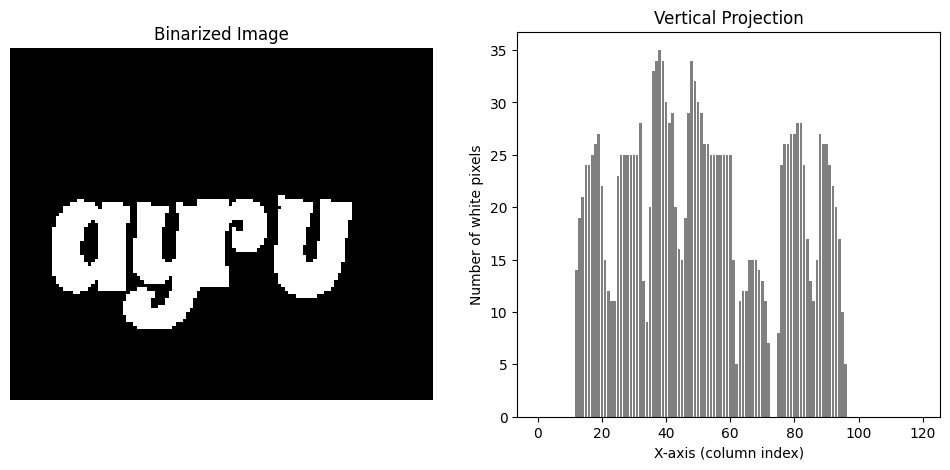

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取圖片為灰階
img = cv2.imread("test.png", cv2.IMREAD_GRAYSCALE)

# 二值化 (Otsu)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 計算垂直投影：每一列的白色像素數
vertical_projection = np.sum(binary == 255, axis=0)

# 顯示原圖與投影長條圖
plt.figure(figsize=(12,5))

# 原圖
plt.subplot(1,2,1)
plt.title("Binarized Image")
plt.imshow(binary, cmap="gray")
plt.axis("off")

# 垂直投影
plt.subplot(1,2,2)
plt.title("Vertical Projection")
plt.bar(range(len(vertical_projection)), vertical_projection, color='gray')
plt.xlabel("X-axis (column index)")
plt.ylabel("Number of white pixels")

plt.show()


## 黏連字母自動定位與切分方法

此方法用於處理驗證碼中可能黏連的字母，主要流程如下：

1. **連通域定位**  
   將驗證碼圖片二值化，利用連通元件分析（Connected Components Analysis, CCA）找到每個白色像素相連的區域。每個區域可能是一個字，也可能是多個黏在一起的字。計算每個區域的中心（centroid）作為原始中心點。

2. **中心修正**  
   計算每個連通域中所有白色像素到中心的最大距離 `max_distance`，並設定基準距離 `k`。  
   - `max_distance <= 2k` → 單字  
   - `2k < max_distance <= 3k` → 兩字黏連  
   - `3k < max_distance <= 4k` → 三字黏連  
   對多字黏連的區域，水平均分生成新的中心點，作為估計的每個字中心。

3. **字母切分與 bounding box 生成**  
   根據每個估計中心點建立矩形邊界框（bounding box）：  
   - 單字母：使用原連通域邊界  
   - 多字黏連：水平範圍均分，矩形框左右各半寬  
   這些 bounding box 可以用於後續字母裁切或識別。

> 總結：此方法結合連通域分析與距離推估，能自動處理黏連字母並定位每個字的位置，適合驗證碼自動分割。


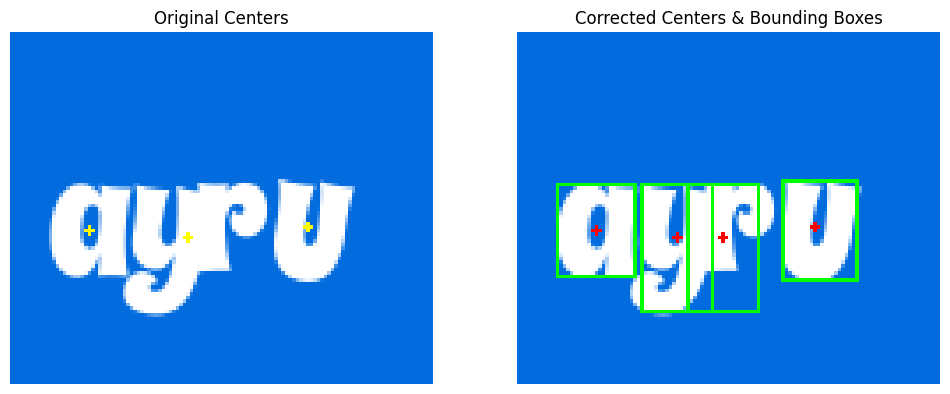

K=25


In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取圖片
img = cv2.imread("test.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 找連通元件
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# 設定字母大小基準距離 k
k = 25

all_centers = []
all_boxes = []

# 複製一張圖用來畫原始中心點
img_centers = img_rgb.copy()

for i in range(1, num_labels):
    ys, xs = np.where(labels == i)
    cX, cY = centroids[i]
    
    # 標示原始中心點 (黃色)
    cv2.circle(img_centers, (int(cX), int(cY)), 1, (255,255,0), -1)
    
    # 計算每個像素到中心距離
    distances = np.sqrt((xs - cX)**2 + (ys - cY)**2)
    max_dist = distances.max()
    
    # 推測黏連字數
    num_letters = int(np.ceil(max_dist / k))
    
    # 生成修正後的中心點
    if num_letters == 1:
        all_centers.append((cX, cY))
        xmin, xmax = xs.min(), xs.max()
        ymin, ymax = ys.min(), ys.max()
        all_boxes.append((xmin, ymin, xmax, ymax))
    else:
        xmin, xmax = xs.min(), xs.max()
        new_centers_x = np.linspace(xmin, xmax, num_letters+2)[1:-1]
        new_centers_y = [cY]*num_letters
        for nx, ny in zip(new_centers_x, new_centers_y):
            all_centers.append((nx, ny))
            # 建立每個字母的 bounding box
            width = (xmax - xmin) / num_letters
            new_xmin = int(nx - width/2)
            new_xmax = int(nx + width/2)
            all_boxes.append((new_xmin, int(ys.min()), new_xmax, int(ys.max())))

# 在原圖上標示修正中心點和 bounding box
img_boxes = img_rgb.copy()
for (cX, cY) in all_centers:
    cv2.circle(img_boxes, (int(cX), int(cY)), 1, (255,0,0), -1)  # 修正中心點藍色

for (xmin, ymin, xmax, ymax) in all_boxes:
    cv2.rectangle(img_boxes, (xmin, ymin), (xmax, ymax), (0,255,0), 1)  # bounding box 綠色

# 顯示對照
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original Centers")
plt.imshow(img_centers)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Corrected Centers & Bounding Boxes")
plt.imshow(img_boxes)
plt.axis("off")

plt.show()
print(f"K={k}")
